# Student_Performance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import scipy
import seaborn as sns
import math

from scipy.io import arff
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (confusion_matrix,plot_confusion_matrix,
                            ConfusionMatrixDisplay,accuracy_score,f1_score,
                            mean_squared_error, mean_absolute_error, max_error,
                            r2_score, explained_variance_score)

from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

## Loading Data

In [2]:
# Datset = pd.read_csv("datasets\Diabetic_Retinopathy\messidor_features.arff") 
Datset = pd.read_csv('/Users/annikatimermanis/Desktop/project/Regression/Regression_Datasets/6_Student_Performance/Student_Performance.csv', delimiter=';') 


In [3]:
df = pd.DataFrame(Datset)
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


## Data Prepration And Analysis

In [5]:
print(np.count_nonzero(Datset==np.nan))

0


In [16]:
# frequency = df['127'].value_counts()
# print(frequency)
# print("---------------------------")

In [9]:
# plt.plot()
# plt.ylabel('Frequency')
# plt.xlabel('Class')
# plt.bar( ("1","0"), frequency)
# plt.suptitle("Distribution")
# plt.show()

In [21]:
# sns.pairplot(df, hue="Class")
# print("ok")

In [18]:
# plt.figure(figsize=(17,17))
# sns.heatmap(df.corr(), annot =True);

## Train and Test set

In [5]:
for column in df:
    if type(df[column][0]) == str:
        # if data in column is type string, we want to convert it to equivalent numerical labels
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(df[column])
        df[column] = integer_encoded

x = df.iloc[:,:-1]
y = df.iloc[:, -1:]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.85, test_size=0.15, random_state=0)

y_train = y_train.to_numpy().reshape(-1)
y_test = y_test.to_numpy().reshape(-1)

In [7]:
StScale = StandardScaler()
X_train = StScale.fit_transform(X_train)
X_test = StScale.transform(X_test)

## Linear Regression

In [8]:
linear_r = LinearRegression()
linear_r.fit(X_train, y_train)

LinearRegression()

## Linear Regression Analysis

In [9]:
linear_r_predict = linear_r.predict(X_test)

In [10]:
accuracy1 = mean_squared_error(y_test, linear_r_predict)
accuracy2 = r2_score(y_test, linear_r_predict)
accuracy3 = explained_variance_score(y_test, linear_r_predict)
    
print('                 MINIMIZE: ')
print("Mean squared error\t", accuracy1)
print('                 MAXIMIZE: ')
print("r2 Score\t\t", accuracy2)
print("Explained Variance Score", accuracy3)
print('---------------------------------------------')

                 MINIMIZE: 
Mean squared error	 1.0665713038425293
                 MAXIMIZE: 
r2 Score		 0.8612538494595052
Explained Variance Score 0.8613404531057484
---------------------------------------------


## Support Vector Regression

In [12]:
svr = SVR().fit(X_train,y_train)

In [13]:
parameters = {
    'C': scipy.stats.uniform(1, 1000), 
    'gamma': scipy.stats.uniform(0.01, 1000)
}
svr_model = RandomizedSearchCV(svr, parameters, verbose=1, n_iter=5, random_state=0).fit(X_train, y_train)
svr_model.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'C': 549.8135039273247, 'gamma': 715.1993663724195}

In [14]:
svr_model.best_estimator_

SVR(C=549.8135039273247, gamma=715.1993663724195)

## Support Vector Regression Analysis

In [16]:
svr_predictions = svr_model.predict(X_test)

In [17]:
accuracy1 = mean_squared_error(y_test, svr_predictions)
accuracy2 = r2_score(y_test, svr_predictions)
accuracy3 = explained_variance_score(y_test, svr_predictions)
print('                 MINIMIZE: ')
print("Mean squared error\t", accuracy1)
print('                 MAXIMIZE: ')
print("r2 Score\t\t", accuracy2)
print("Explained Variance Score", accuracy3)
print('---------------------------------------------')

                 MINIMIZE: 
Mean squared error	 7.7320558293178125
                 MAXIMIZE: 
r2 Score		 -0.00583334486601661
Explained Variance Score 0.0
---------------------------------------------


## Decision Tree Regression

In [18]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

DecisionTreeRegressor()

## Decision tree Analysis

In [19]:
tree_predictions = tree.predict(X_test)

In [20]:
accuracy1 = mean_squared_error(y_test, tree_predictions)
accuracy2 = r2_score(y_test, tree_predictions)
accuracy3 = explained_variance_score(y_test, tree_predictions)
print('                 MINIMIZE: ')
print("Mean squared error\t", accuracy1)
print('                 MAXIMIZE: ')
print("r2 Score\t\t", accuracy2)
print("Explained Variance Score", accuracy3)
print('---------------------------------------------')

                 MINIMIZE: 
Mean squared error	 1.3571428571428572
                 MAXIMIZE: 
r2 Score		 0.8234545159018258
Explained Variance Score 0.8257436203066587
---------------------------------------------


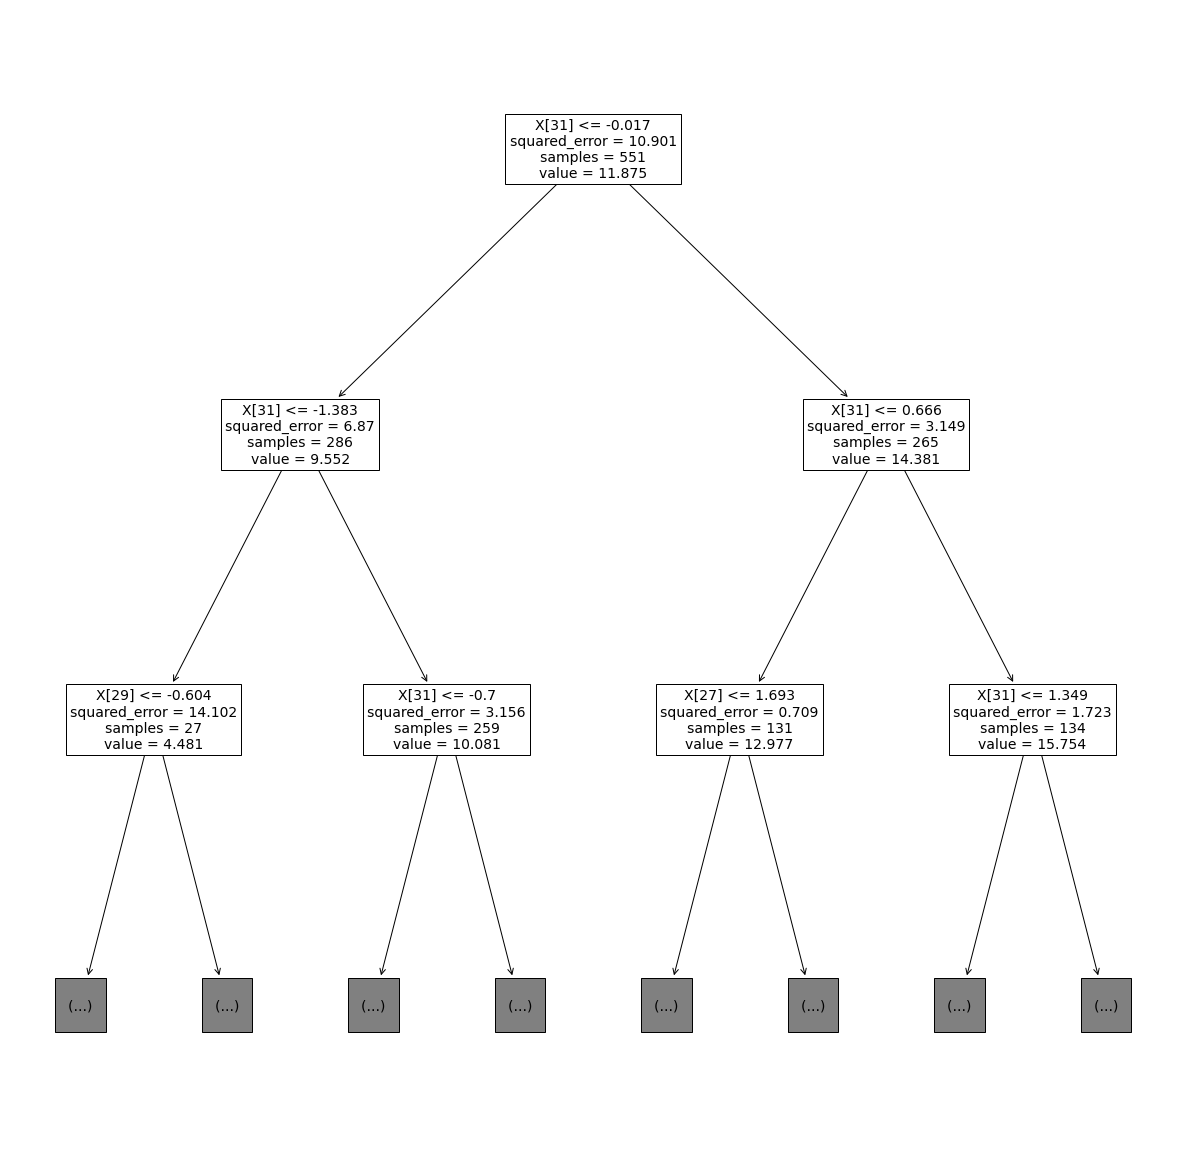

In [21]:
plt.figure(figsize=(21,21))
plot_tree(tree, max_depth = 2, fontsize=14);

## Random Forest Regression

In [23]:
forest = RandomForestRegressor()
forest = forest.fit(X_train, y_train)

## Random Forest Analysis

In [24]:
forest_predictions = forest.predict(X_test)

In [25]:
accuracy1 = mean_squared_error(y_test, forest_predictions)
accuracy2 = r2_score(y_test, forest_predictions)
accuracy3 = explained_variance_score(y_test, forest_predictions)
print('                 MINIMIZE: ')
print("Mean squared error\t", accuracy1)
print('                 MAXIMIZE: ')
print("r2 Score\t\t", accuracy2)
print("Explained Variance Score", accuracy3)
print('---------------------------------------------')

                 MINIMIZE: 
Mean squared error	 1.2081734693877553
                 MAXIMIZE: 
r2 Score		 0.8428333694533239
Explained Variance Score 0.8429249336295173
---------------------------------------------


## K Nearest Neighbours Regression

In [50]:
# knn = KNeighborsClassifier()

In [85]:
# parameters = {
#     'n_neighbors': range(1, 100), 
#     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
#     'weights': ['uniform', 'distance'], 
#     'leaf_size': scipy.stats.uniform(1, 50)
# }
# knn_model = RandomizedSearchCV(knn, parameters,verbose=10,random_state=0).fit(X_train, y_train)
# knn_model.best_params_

In [56]:
# knn_model.best_estimator_

KNeighborsClassifier(algorithm='kd_tree', leaf_size=41.60843643877466,
                     n_neighbors=47)

## KNN Analysis

In [57]:
knn_predictions = knn_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.55      0.82      0.66       101
           1       0.78      0.48      0.60       130

    accuracy                           0.63       231
   macro avg       0.67      0.65      0.63       231
weighted avg       0.68      0.63      0.63       231

[[83 18]
 [67 63]]
0.6320346320346321
0.6252257337773095
0.6292554898887861


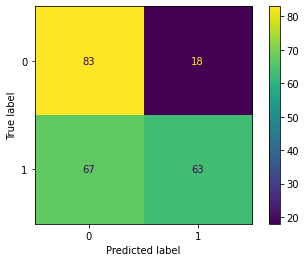

In [59]:
# print(classification_report(y_test, knn_predictions))
# print(confusion_matrix (y_test, knn_predictions))
# print(accuracy_score(y_test, knn_predictions))
# print(f1_score(y_test, knn_predictions, average='weighted'))
# print(f1_score(y_test, knn_predictions, average='macro'))
# ConfusionMatrixDisplay.from_predictions(y_test, knn_predictions);